# E-commerce Customer Churn
***

## 1. Business Problem Understanding

**Context**

An online retail (e-commerce) company seeks to identify customers who are likely to churn. By doing so, they can take proactive measures to engage these customers. The company intends to offer targeted promotions in an effort to retain them.

**Target**
* 0: Customer won't churn
* 1: Customer will churn

**Problem Statement**

Customer churn refers to the situation where a customer chooses to stop using a company's products or services, effectively ending their relationship with the business. This can have a direct impact on key aspects such as revenue, growth, & even brand reputation. When a customer leaves, the business loses not only the sales from that customer but also potential future revenue. 

Moreover, a high churn rate can indicate that many customers are leaving, signalling dissatisfaction with the company's products or services. This could harm the brand, as unhappy customers may leave negative reviews or share bad experiences. Such outcomes can hinder business growth & in extreme cases, threaten the survival of the company. Building and maintaining long-term relationships with customers is crucial for sustainable growth & a high churn rate disrupts this essential cycle.

**Goals**

Based on this issue, the company wants to have the ability to predict whether a customer will churn or not. Furthermore, the company aims to identify the factor & variables that influence a customer’s decision tchurnve, allowing them to take proactive actions and prevent churn as early as possible. By understanding these key drivers, the company can better tailor its strategies and interventions to improve customer retention and reduce the risk of losing valuable client

**Analytical Approach**

So, what we will do is analyze the data to identify patterns that differentiate customers who will churn from those who will not. Then, we will build a classification model that will help the company predict the probability of a customer churning or staying, allowing them to take timely preventive actions.

**Metric Evaluation**

![Confusion Matrix](https://h2o.ai/wiki/confusion-matrix/_jcr_content/root/section/par/advancedcolumncontro_1271832721/columns1/image.coreimg.jpeg/1689866291131/confusion-matrix.jpeg)

Type 1 Error (False Positive)
> Consequence: Incorrectly offering a promotion to a customer who is not at risk of churning.

Type 2 Error (False Negative)
> Consequence: Failing to offer retention treatment to a customer who is actually at risk of churning, because they were predicted as not likely to churn.

In customer churn analysis, a higher False Negative rate results in greater profit losses, causing more financial harm compared to False Positives. Therefore, the F2 Score is the most suitable metric as it places greater emphasis on minimizing False Negatives while still considering False Positives. Reducing False Positives is also crucial to ensure promotions are targeted at customers who are genuinely at risk of churning.

## 2. Data Understanding

### 2.1. Import Libraries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import kruskal, ks_2samp, mannwhitneyu
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler, StandardScaler

# Modeling
from lightgbm import LGBMClassifier, plot_importance
import shap
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score, make_scorer, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import XGBClassifier

# Imbalance
from imblearn.over_sampling import ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Model Saving
import pickle

### 2.2. Import Data

In [2]:
df = pd.read_csv('data_ecommerce_customer_churn.csv')
display(df.head(), df.tail())

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0
3939,6.0,NaN,4,Mobile,3,Married,10,1,0.0,124.37,1
3940,2.0,7.0,3,Laptop & Accessory,5,Married,1,0,2.0,153.73,0


### 2.3. Basic Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


In [4]:
pd.set_option('display.max_colwidth', None)

list_data = []

for col in df.columns:
    list_data.append([col, df[col].dtype, df[col].isnull().sum(), round(df[col].isnull().sum() / df.shape[0] * 100, 2),
                     df[col].nunique(), df[col].unique()[:5]])

pd.DataFrame(data=list_data, columns=['column', 'type', 'null', 'null_pct', 'unique', 'values'])

,column,type,null,null_pct,unique,values
0,Tenure,float64,194,4.92,36,"[15.0, 7.0, 27.0, 20.0, 30.0]"
1,WarehouseToHome,float64,169,4.29,33,"[29.0, 25.0, 13.0, 15.0, 16.0]"
2,NumberOfDeviceRegistered,int64,0,0.00,6,"[4, 3, 6, 2, 5]"
3,PreferedOrderCat,object,0,0.00,6,"[Laptop & Accessory, Mobile, Fashion, Others, Mobile Phone]"
4,SatisfactionScore,int64,0,0.00,5,"[3, 1, 4, 2, 5]"
5,MaritalStatus,object,0,0.00,3,"[Single, Married, Divorced]"
6,NumberOfAddress,int64,0,0.00,14,"[2, 5, 7, 8, 3]"
7,Complain,int64,0,0.00,2,"[0, 1]"
8,DaySinceLastOrder,float64,213,5.40,22,"[7.0, nan, 8.0, 11.0, 2.0]"
9,CashbackAmount,float64,0,0.00,2335,"[143.32, 129.29, 168.54, 230.27, 322.17]"


Notes:
* There are 9 numerical columns and 2 categorical columns.
* The 2 categorical columns don't have high cardinality, so there is no need to perform `BinaryEncoder`.
* The columns with missing values are: `Tenure`, `WarehouseToHome`, & `DaySinceLastOrder`.
* All columns appear to be useful & there is no column that contains only 1 unique value.
* The `PreferedOrderCat` has two identical values: 'Mobile' & 'Mobile Phone'. We can change this to just one value.

In [5]:
display(df.describe(), df.describe(include='object'))

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
count,3747.000000,3772.000000,3941.000000,3941.000000,3941.000000,3941.000000,3728.000000,3941.000000,3941.000000
mean,10.081398,15.650583,3.679269,3.088302,4.237757,0.282416,4.531652,176.707419,0.171023
std,8.498864,8.452301,1.013938,1.381832,2.626699,0.450232,3.667648,48.791784,0.376576
min,0.000000,5.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,9.000000,3.000000,2.000000,2.000000,0.000000,2.000000,145.700000,0.000000
50%,9.000000,14.000000,4.000000,3.000000,3.000000,0.000000,3.000000,163.340000,0.000000
75%,16.000000,21.000000,4.000000,4.000000,6.000000,1.000000,7.000000,195.250000,0.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,1.000000,46.000000,324.990000,1.000000


,PreferedOrderCat,MaritalStatus
count,3941,3941
unique,6,3
top,Laptop & Accessory,Married
freq,1458,2055


In [6]:
df['PreferedOrderCat'] = df['PreferedOrderCat'].replace('Mobile Phone', 'Mobile')

In [7]:
print(f'Total rows that have at least 1 missing value: {df.isnull().any(axis=1).sum()} ({round(df.isnull().any(axis=1).sum() / df.shape[0] * 100, 2)})%')

Total rows that have at least 1 missing value: 576 (14.62)%


In [8]:
print(f'Total duplicated rows: {df.duplicated().sum()} ({round(df.duplicated().sum() / df.shape[0] * 100, 2)})%')

Total duplicated rows: 672 (17.05)%


In [9]:
df = df.drop_duplicates()
print(f"Shape after removing duplicates: {df.shape}")
print(f"Total rows with at least one missing value after removing duplicates: {df.isnull().any(axis=1).sum()} ({round(df.isnull().any(axis=1).sum() / df.shape[0] * 100, 2)})%")

Shape after removing duplicates: (3269, 11)
Total rows with at least one missing value after removing duplicates: 475 (14.53)%


## 3. Exploratory Data Analysis

### Churn Proportion

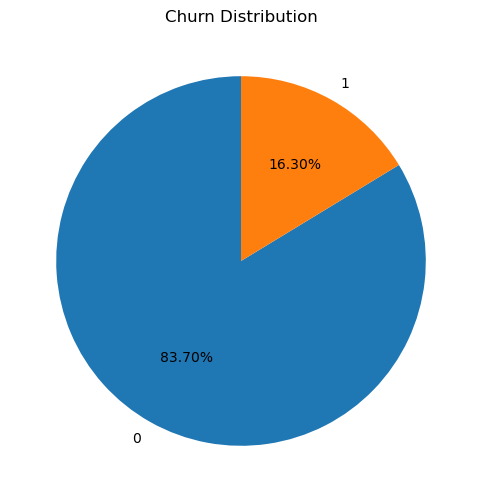

In [10]:
plt.figure(figsize=(6, 6))

df['Churn'].value_counts().plot.pie(autopct='%1.2f%%', startangle=90)
plt.title('Churn Distribution')
plt.ylabel('') 
plt.show()

### Distribution of Numerical Variables

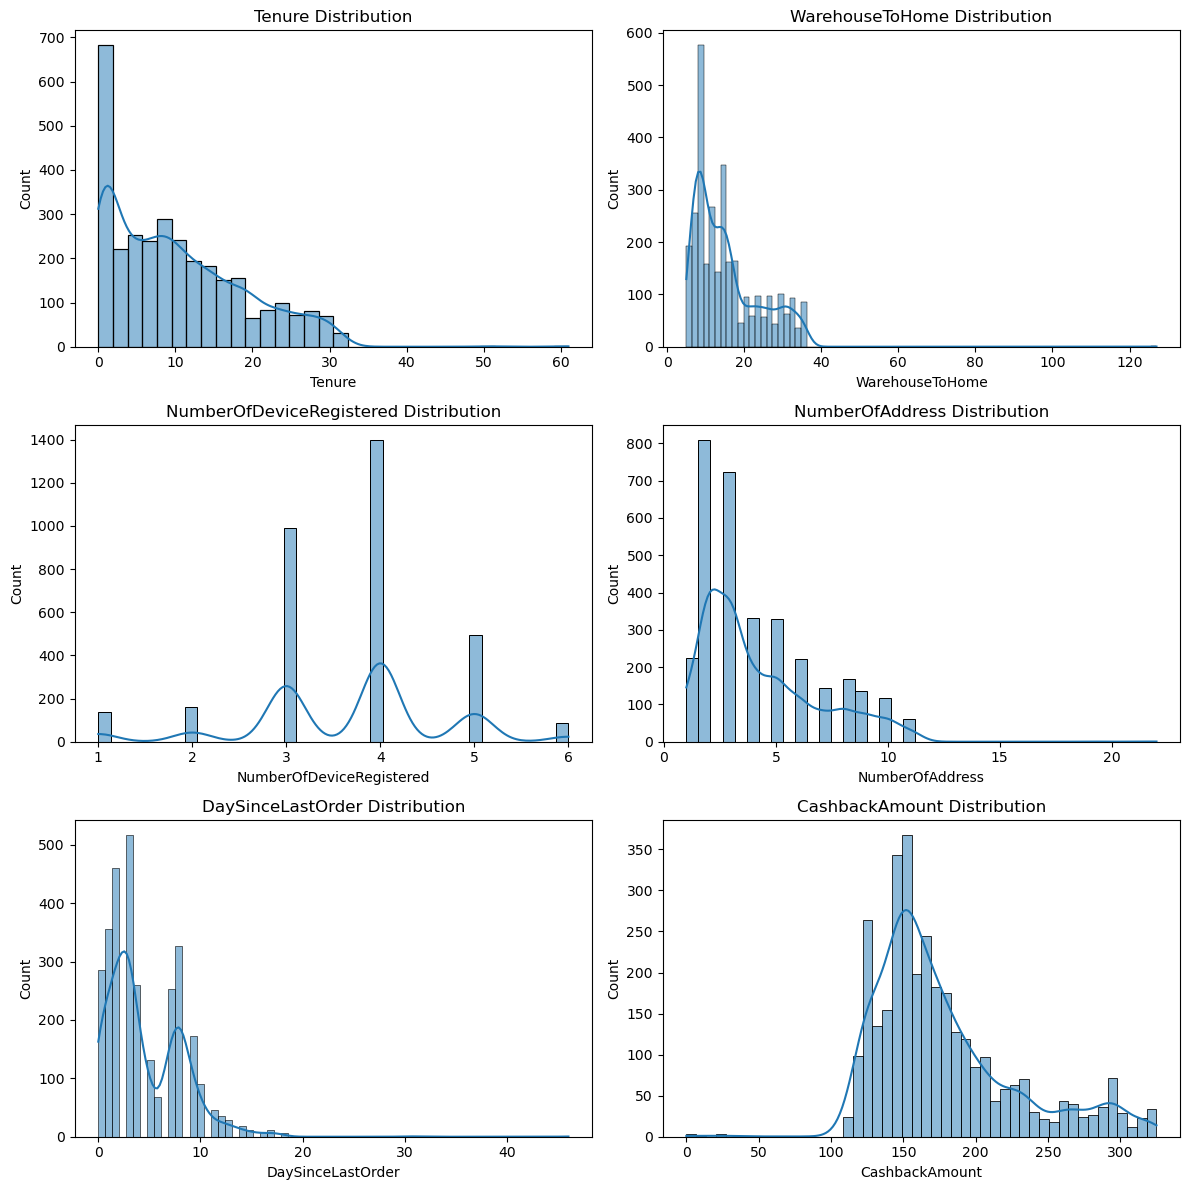

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

ax = ax.flatten()

for i, col in enumerate(['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'DaySinceLastOrder', 'CashbackAmount']):
    sns.histplot(data=df, x=col, kde=True, ax=ax[i])
    ax[i].set_title(f'{col} Distribution')
    ax[i].set_xlabel(f'{col}')
    ax[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

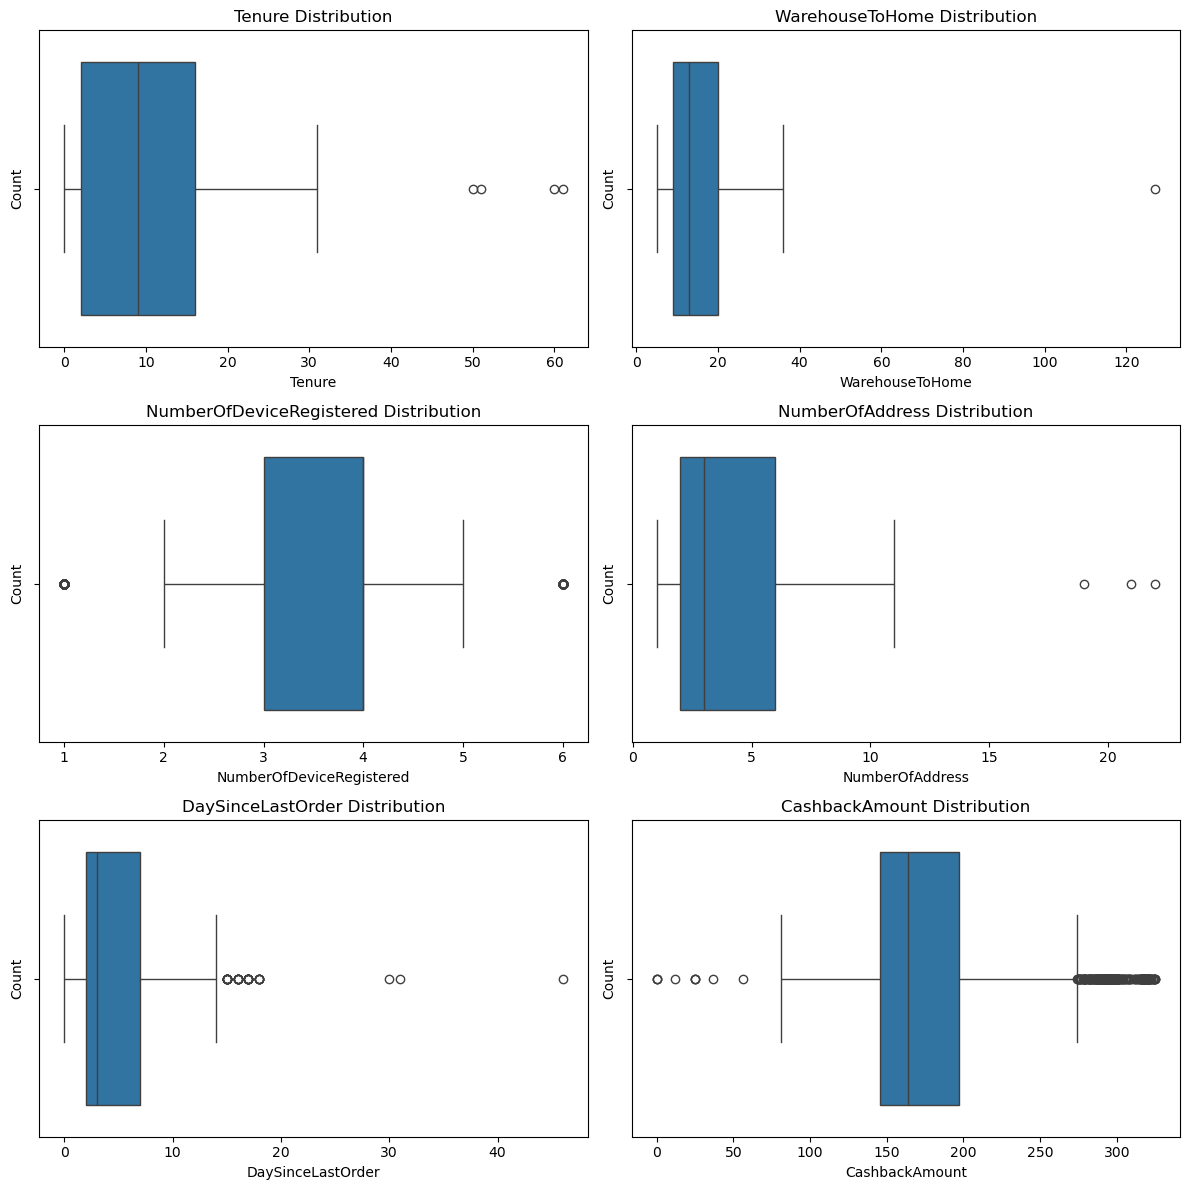

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

ax = ax.flatten()

for i, col in enumerate(['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'DaySinceLastOrder', 'CashbackAmount']):
    sns.boxplot(data=df, x=col, ax=ax[i])
    ax[i].set_title(f'{col} Distribution')
    ax[i].set_xlabel(f'{col}')
    ax[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

Notes:
* All numerical variables here have outliers.
* Their distributions also appear to be right-skewed, except for the `NumberOfDeviceRegistered`.
* There are no outlier values that are very strange; everything still seems reasonable.

### Distribution of Categorical Variables

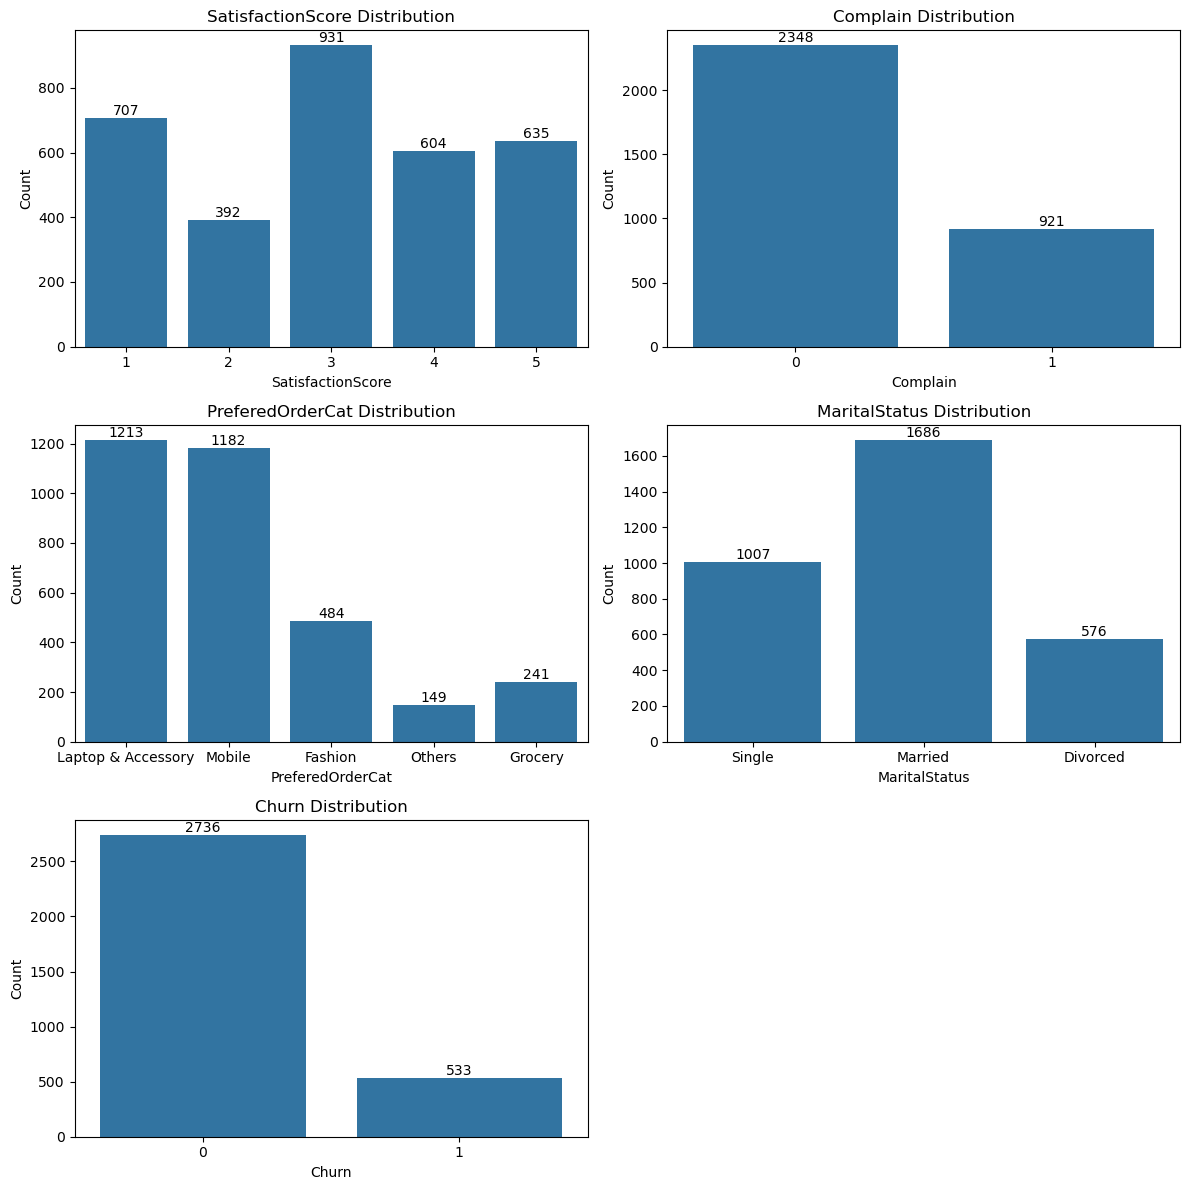

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

ax = ax.flatten()

for i, col in enumerate(['SatisfactionScore', 'Complain', 'PreferedOrderCat', 'MaritalStatus', 'Churn']):
    sns.countplot(data=df, x=col, ax=ax[i])
    ax[i].set_title(f'{col} Distribution')
    ax[i].set_xlabel(f'{col}')
    ax[i].set_ylabel('Count')
    
    for container in ax[i].containers:
        ax[i].bar_label(container)

fig.delaxes(ax[5])
plt.tight_layout()
plt.show()

Notes:
* From the `SatisfactionScore`, most users chose number 3, followed by number 4. This could indicate that there are many issues.
* However, these users most likely don't like to complain, which is why the value of 0 is much higher compared to 1.
* Most users preferred to order 'Laptop & Accessory' and 'Mobile', with their numbers significantly higher than the others.
* Most users are married.
* There is imbalanced data in `churn`, with the number of churned users being much smaller than those who did not churn.

### Churn Distribution by Numerical Variables

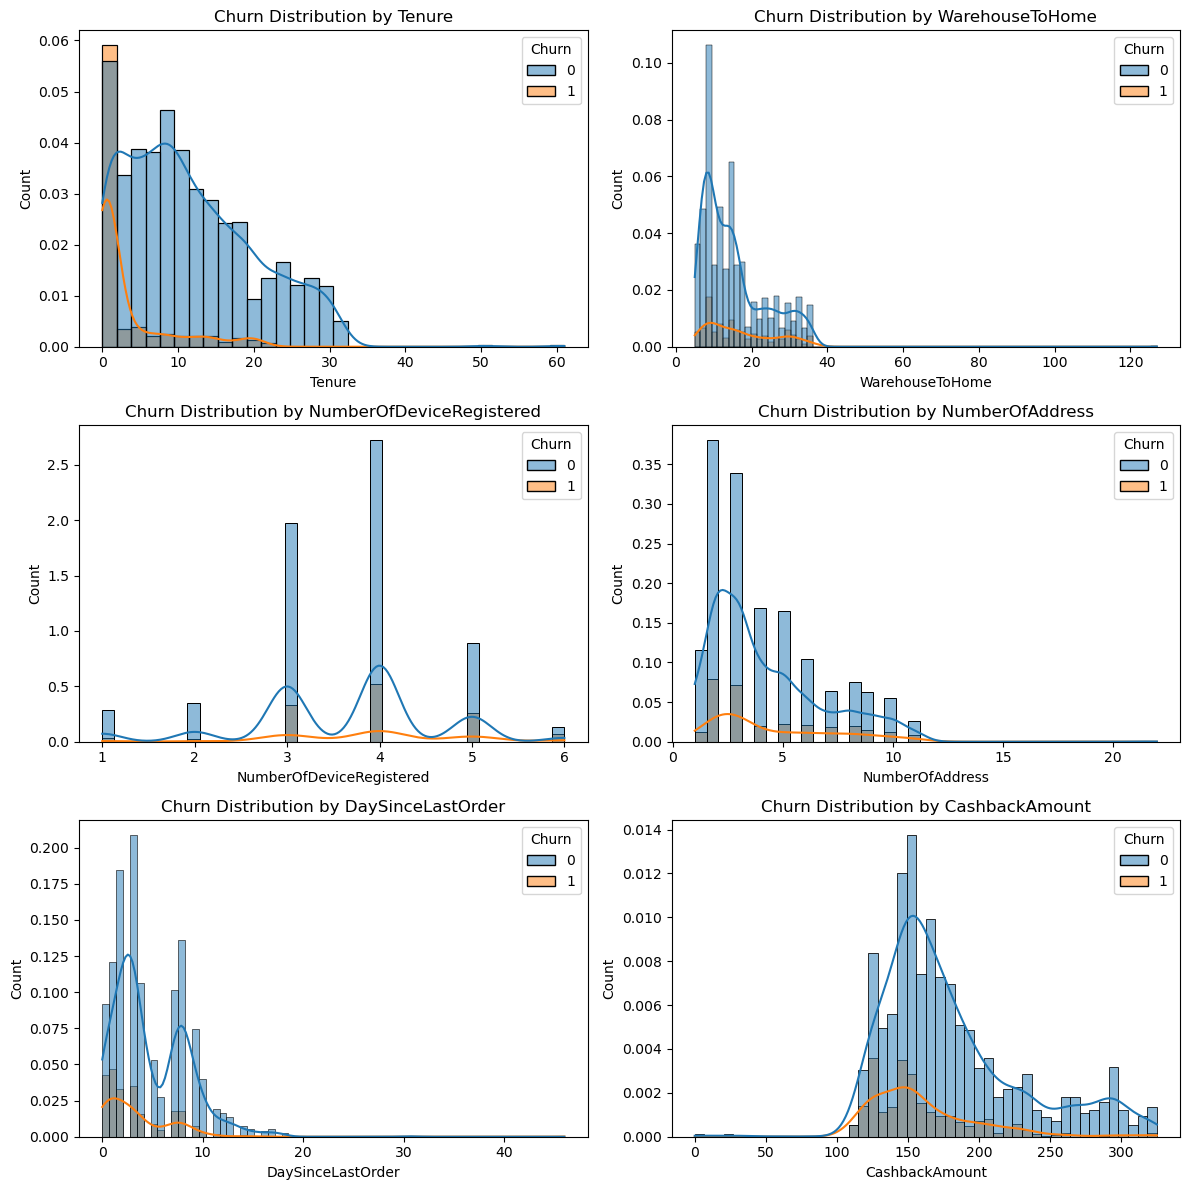

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

ax = ax.flatten()

for i, col in enumerate(['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'DaySinceLastOrder', 'CashbackAmount']):
    sns.histplot(data=df, x=col, kde=True, hue='Churn', ax=ax[i], stat='density')
    ax[i].set_title(f'Churn Distribution by {col}')
    ax[i].set_xlabel(f'{col}')
    ax[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

Notes:
* Customers with shorter tenures appear to have a higher churn rate, as indicated by the orange bars peaking at lower values (even more than blue bars).
* Non-churn customers (blue) seem to dominate at longer tenures.
* `Tenure` stands out as the variable with the clearest differentiation between churn and non-churn customers. This variable could be a strong predictor for the model.

### Churn Proportion by Categorical Variables

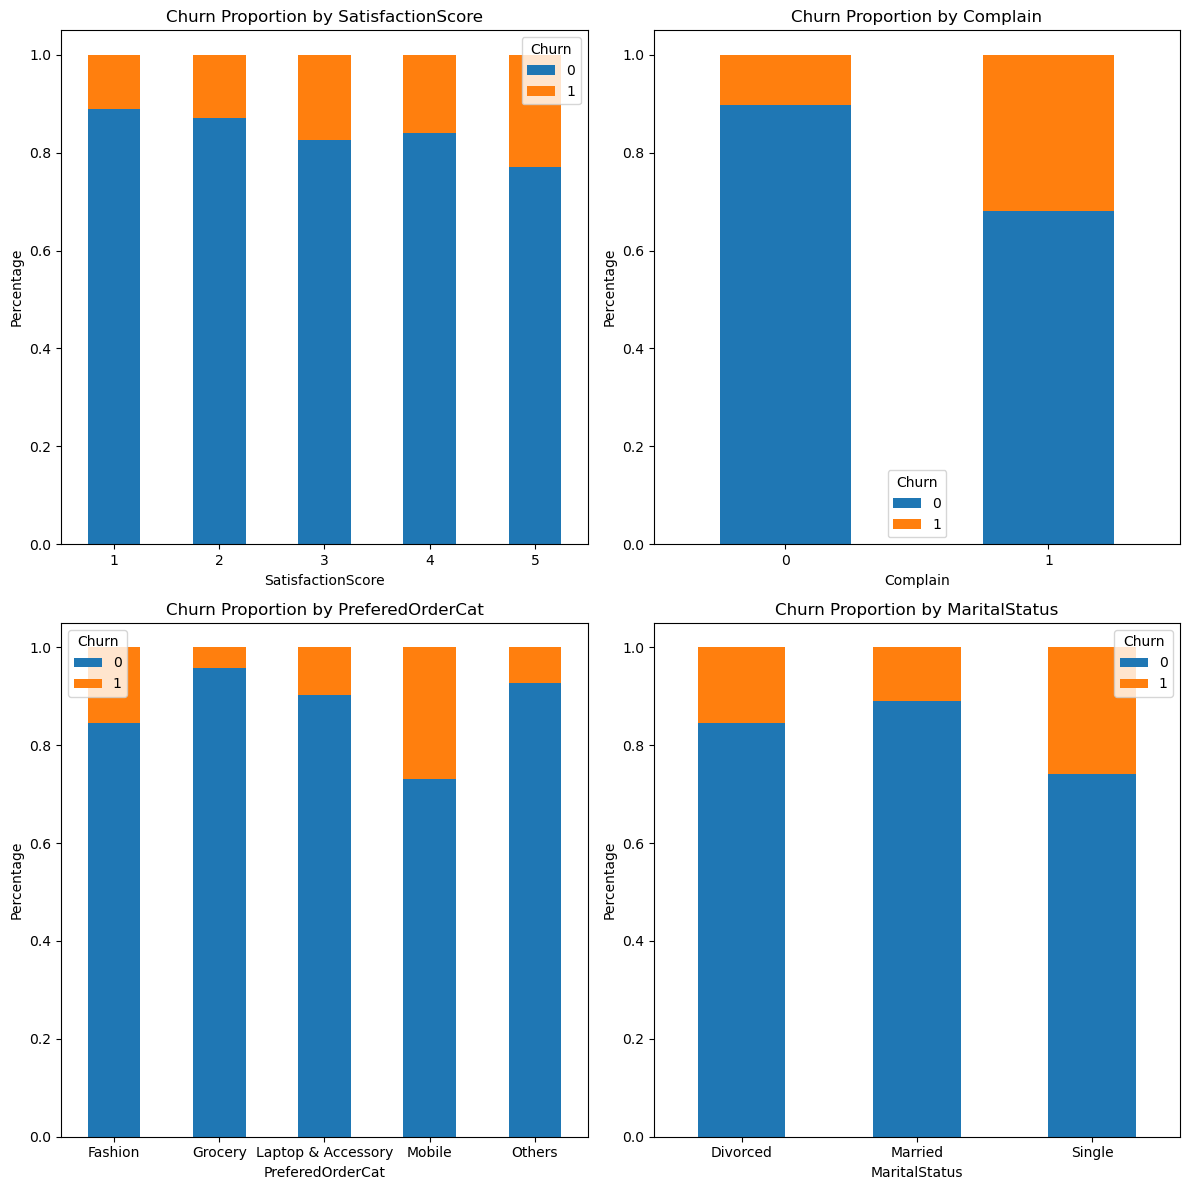

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

ax = ax.flatten()

for i, col in enumerate(['SatisfactionScore', 'Complain', 'PreferedOrderCat', 'MaritalStatus']):
    pd.crosstab(df[col], df['Churn'], normalize=0).plot(kind='bar', stacked=True, ax=ax[i])
    ax[i].set_title(f'Churn Proportion by {col}')
    ax[i].set_xlabel(f'{col}')
    ax[i].set_ylabel('Percentage')
    ax[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

Notes:
* It's quite surprising that users who gave a rating of 4 or 5 for `SatisfactionScore` tend to churn a little bit higher than those who gave a rating of 1 or 2.
* For `Complain`, users who reported complaints are more likely to churn than those who didn't.
* Users who prefer the 'Mobile' order category have a higher churn proportion, followed by those who prefer 'Fashion,' with both categories having higher churn than others.
* 'Single' users tend to churn more than others users.

### Correlation Matrix among Numerical Variables

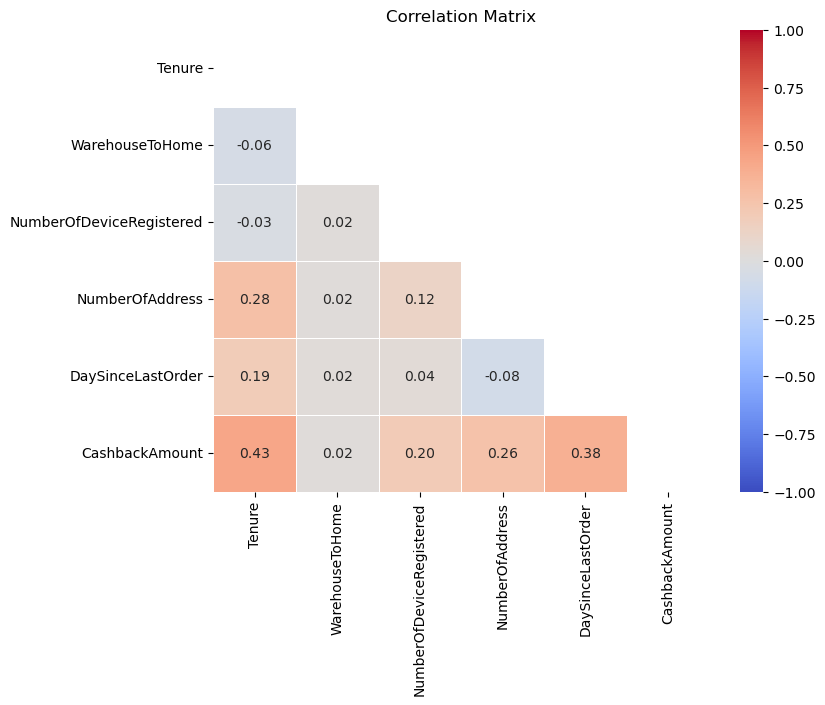

In [16]:
corr_matrix = df[['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'DaySinceLastOrder', 'CashbackAmount']].corr(method='spearman')

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

Notes:
* Medium correlation (0.40 - 0.599): `Tenure`-`CashbackAmount`, `DaySinceLastOrder`-`CashbackAmount`.
* Weak correlation (0.20 - 0.399): `Tenure`-`NumberOfAddress`, `NumberOfDeviceRegistered`-`CashbackAmount`, `NumberOfAddress`-`CashbackAmount`.

## 4. Data Preprocessing

### 4.1. Train-Test Split

In [17]:
X = df.drop(columns=['Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2615 entries, 3504 to 1718
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    2492 non-null   float64
 1   WarehouseToHome           2509 non-null   float64
 2   NumberOfDeviceRegistered  2615 non-null   int64  
 3   PreferedOrderCat          2615 non-null   object 
 4   SatisfactionScore         2615 non-null   int64  
 5   MaritalStatus             2615 non-null   object 
 6   NumberOfAddress           2615 non-null   int64  
 7   Complain                  2615 non-null   int64  
 8   DaySinceLastOrder         2470 non-null   float64
 9   CashbackAmount            2615 non-null   float64
dtypes: float64(4), int64(4), object(2)
memory usage: 224.7+ KB


In [19]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 654 entries, 1028 to 2242
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    618 non-null    float64
 1   WarehouseToHome           625 non-null    float64
 2   NumberOfDeviceRegistered  654 non-null    int64  
 3   PreferedOrderCat          654 non-null    object 
 4   SatisfactionScore         654 non-null    int64  
 5   MaritalStatus             654 non-null    object 
 6   NumberOfAddress           654 non-null    int64  
 7   Complain                  654 non-null    int64  
 8   DaySinceLastOrder         618 non-null    float64
 9   CashbackAmount            654 non-null    float64
dtypes: float64(4), int64(4), object(2)
memory usage: 56.2+ KB


### 4.2. Missing Values

Columns with missing values:
* `Tenure`
* `WarehouseToHome`
* `DaySinceLastOrder`

All of these columns are numerical. My initial approach to handle the missing values is by imputing based on the categorical value of another variable. To identify which variables influence the missing data, I will use statistical tests such as the Mann-Whitney or Kruskal-Wallis Test, since the numerical values are not normally distributed. This approach is preferable over using the mean or median of the numerical variables because it accounts for the relationship between the missing data and other variables, ensuring that underlying patterns are not ignored. Imputing with the global mean or median could distort the data's distribution, particularly if the variable is skewed or contains outliers.

After identifying the relevant variables, I will check for any changes in the distribution before and after imputation. This step is crucial because if the imputation alters the data's distribution too much, it could introduce biases or distort the underlying patterns in the data. By comparing the distribution before and after imputation, I can ensure that the imputed values are consistent with the original data's structure and characteristics. If there is a significant shift in the distribution, it may suggest that the imputation method is not appropriate and could negatively affect the results of any subsequent analysis or models.

Of course, I will also experiment with IterativeImputer to compare & determine which imputation method works best later.

In [20]:
def check_significance(df, missing_cols):
    """
    Check the significance between categorical variables and numerical columns 
    with missing values by performing statistical tests (Kruskal-Wallis for 
    multi-category and Mann-Whitney for binary).
    
    Parameters:
    - df: pd.DataFrame: The dataset containing categorical variables and numerical columns.
    - missing_cols: list: A list of numerical columns with missing values.
    
    Returns:
    - None: Prints p-values for each numerical column tested against the categorical variables.
    """
    
    categorical_cols = ['PreferedOrderCat', 'MaritalStatus', 'SatisfactionScore']

    for numerical_col in missing_cols:
        var_names = [] 
        p_vals = []
        
        valid_df = df.dropna(subset=[numerical_col] + categorical_cols)
        
        for categorical_col in categorical_cols:
            num_categories = valid_df[categorical_col].nunique()

            if num_categories > 2:
                groups = [valid_df[valid_df[categorical_col] == category][numerical_col] for category in valid_df[categorical_col].unique()]
                stat, p_val = kruskal(*groups)
            else:
                group1 = valid_df[valid_df[categorical_col] == valid_df[categorical_col].unique()[0]][numerical_col]
                group2 = valid_df[valid_df[categorical_col] == valid_df[categorical_col].unique()[1]][numerical_col]
                stat, p_val = mannwhitneyu(group1, group2)
            
            var_names.append(categorical_col)
            p_vals.append(p_val)

        result = pd.DataFrame({
            'Categorical': var_names,
            'P-Value': p_vals
        }).sort_values(by='P-Value', ascending=True)
        
        print(f"Significance for {numerical_col} with missing values:")
        print(result)
        print("-" * 50)

In [21]:
check_significance(df=X_train, missing_cols=['Tenure', 'WarehouseToHome', 'DaySinceLastOrder'])

Significance for Tenure with missing values:
         Categorical        P-Value
0   PreferedOrderCat  1.490606e-127
1      MaritalStatus   4.128964e-08
2  SatisfactionScore   5.656596e-02
--------------------------------------------------
Significance for WarehouseToHome with missing values:
         Categorical   P-Value
0   PreferedOrderCat  0.000158
1      MaritalStatus  0.068032
2  SatisfactionScore  0.452285
--------------------------------------------------
Significance for DaySinceLastOrder with missing values:
         Categorical       P-Value
0   PreferedOrderCat  3.577705e-65
1      MaritalStatus  2.794834e-04
2  SatisfactionScore  9.717197e-02
--------------------------------------------------


Notes:
* The p-values for `PreferedOrderCat` is much lower compared to `MaritalStatus`, which suggests that these variables have a stronger relationship with the numerical variables & are likely more significant.
* I will use `PreferedOrderCat` to impute the missing values, based on the median value for each group.

In [22]:
X_train.groupby(['PreferedOrderCat', 'MaritalStatus'])['Tenure'].agg(
    median='median', 
    count='count',
    null_count=lambda x: x.isnull().sum()
).reset_index()

,PreferedOrderCat,MaritalStatus,median,count,null_count
0,Fashion,Divorced,10.0,61,0
1,Fashion,Married,11.0,219,0
2,Fashion,Single,12.0,109,0
3,Grocery,Divorced,23.0,43,0
4,Grocery,Married,20.0,112,0
5,Grocery,Single,22.0,53,0
6,Laptop & Accessory,Divorced,6.0,157,2
7,Laptop & Accessory,Married,9.0,525,4
8,Laptop & Accessory,Single,8.0,279,0
9,Mobile,Divorced,5.0,145,21


In [23]:
X_train.groupby(['PreferedOrderCat', 'MaritalStatus'])['WarehouseToHome'].agg(
    median='median', 
    count='count',
    null_count=lambda x: x.isnull().sum()
).reset_index()

,PreferedOrderCat,MaritalStatus,median,count,null_count
0,Fashion,Divorced,15.0,61,0
1,Fashion,Married,14.0,219,0
2,Fashion,Single,14.0,109,0
3,Grocery,Divorced,14.0,43,0
4,Grocery,Married,12.0,112,0
5,Grocery,Single,10.0,53,0
6,Laptop & Accessory,Divorced,13.0,158,1
7,Laptop & Accessory,Married,14.0,527,2
8,Laptop & Accessory,Single,12.0,277,2
9,Mobile,Divorced,13.5,144,22


In [24]:
X_train.groupby(['PreferedOrderCat', 'MaritalStatus'])['DaySinceLastOrder'].agg(
    median='median', 
    count='count',
    null_count=lambda x: x.isnull().sum()
).reset_index()

,PreferedOrderCat,MaritalStatus,median,count,null_count
0,Fashion,Divorced,7.0,41,20
1,Fashion,Married,7.0,162,57
2,Fashion,Single,7.0,76,33
3,Grocery,Divorced,8.0,41,2
4,Grocery,Married,7.0,105,7
5,Grocery,Single,5.0,53,0
6,Laptop & Accessory,Divorced,4.0,156,3
7,Laptop & Accessory,Married,4.0,512,17
8,Laptop & Accessory,Single,4.0,273,6
9,Mobile,Divorced,3.0,166,0


In [25]:
class GroupMedianImputer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to impute missing values using the median of each group.
    The group is determined based on one or more categorical columns.
    """

    def __init__(self, group_cols):
        """
        Initializes the imputer with the list of group columns.

        Parameters:
        - group_cols: list or str: One or more categorical columns to group by.
        """ 
        self.group_cols = group_cols
        self.median_values_ = None

    def fit(self, X, y=None):
        """
        Compute the medians for each group based on the specified categorical columns.
        
        Parameters:
        - X: pandas.DataFrame: The input data with features.
        
        Returns:
        - self: The fitted transformer.
        """
        self.median_values_ = X.groupby(self.group_cols).median(numeric_only=True)
        return self

    def transform(self, X):
        """
        Impute missing values based on the computed medians from `fit()`.
        
        Parameters:
        - X: pandas.DataFrame: The data to transform (with missing values to impute).
        
        Returns:
        - X_transformed: pandas.DataFrame: The data with missing values imputed.
        """
        X_copy = X.copy()
        
        for col in X_copy.columns:
            if col not in self.group_cols:
                if X_copy[col].isnull().sum() > 0:
                    X_copy[col] = X_copy.apply(
                        lambda row: self.median_values_.loc[tuple(row[self.group_cols]), col] if pd.isnull(row[col]) else row[col], axis=1
                    )
        
        return X_copy

    def get_feature_names_out(self, input_features=None):
        """
        Return the feature names after transformation.
        This is needed for compatibility with ColumnTransformer and pipelines.
        """
        if input_features is not None:
            return input_features
        else:
            return self.group_cols
        
    def KS_test(self, X_original, X_imputed, col):
        """
        Perform Kolmogorov-Smirnov test to check if the distribution has changed 
        after imputing missing values for a specific column, grouped by `group_cols`.
        
        Parameters:
        - X_original: pandas.DataFrame: The original dataset (before imputation).
        - X_imputed: pandas.DataFrame: The dataset after imputation.
        - col: str: The column for which the KS test should be applied.
        
        Returns:
        - None: The p-value is printed when p-value < 0.05.
        """
        # Group the data by the categorical columns
        for _, group_data in X_original.groupby(self.group_cols):
            # Filter the data for the current group in the original data
            group_original = group_data[[col] + self.group_cols].dropna(subset=[col])  # Original data for the group
            
            # Print original group data (for debugging)
            #print(f"Original group data for {group_data[self.group_cols].iloc[0]}:")
            #print(group_original)
            
            # Filter the imputed data for the current group based on group values
            group_values = group_data[self.group_cols].iloc[0].to_dict()  # Get the group values as a dictionary
            
            # Filter the imputed data using the group values
            group_imputed = X_imputed[
                (X_imputed[self.group_cols[0]] == group_values[self.group_cols[0]]) & 
                (X_imputed[self.group_cols[1]] == group_values[self.group_cols[1]])
            ][col].dropna()  # Imputed data for the group
            
            # Print imputed group data (for debugging)
            #print(f"Imputed group data for {group_values}:")
            #print(group_imputed)
            
            # Ensure that both the original and imputed groups are non-empty
            if group_original.empty or group_imputed.empty:
                print(f"Skipping KS test for group {group_values} (column {col}) because one of the groups is empty.")
                continue

            # Perform the KS test to compare the distributions of the original and imputed data
            stat, p_value = ks_2samp(group_original[col], group_imputed)
            
            # Interpretation of the KS test result
            if p_value < 0.05:
                print(f"KS test for group {group_values} (column {col}):")
                print(f"KS Statistic: {stat}, P-value: {p_value}")
                print(f"Distributions for group {group_values} are significantly different (p < 0.05).")
                print("-" * 100)

In [26]:
imputer = GroupMedianImputer(group_cols=['PreferedOrderCat', 'MaritalStatus'])

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# X_test_imputed.loc[(X_test['Tenure'].isnull()) & (X_test_imputed['PreferedOrderCat'] == 'Mobile') & (X_test_imputed['MaritalStatus'] == 'Married'), 'Tenure']

In [27]:
for col in ['Tenure', 'WarehouseToHome', 'DaySinceLastOrder']:
    imputer.KS_test(X_train, X_train_imputed, col)

### 4.3. Encoding

In [28]:
encoder = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), ['PreferedOrderCat', 'MaritalStatus'])
], remainder='passthrough')

data_train_encoded = encoder.fit_transform(X_train_imputed)
data_test_encoded = encoder.transform(X_test_imputed)

encoded_columns = encoder.get_feature_names_out()
encoded_columns = [x.replace('remainder__', '') for x in encoded_columns]

X_train_encoded = pd.DataFrame(data=data_train_encoded, columns=encoded_columns)
X_test_encoded = pd.DataFrame(data=data_test_encoded, columns=encoded_columns)

### 4.4. Scaling

In [29]:
scaler = StandardScaler()

## 5. Modeling & Evaluation

#### Assumptions for Business Profit/Loss Calculation:

- **Prediction period:** Next Month

- **Projected ARPU:** US$400

- **Marketing cost (including cashback):** US$152

Based on the cashback amount distribution, users receiving a **cashback of $150 or more** tend to have a **lower churn rate (12%)**

### Function

In [30]:
def models_evaluation(X_train, y_train, X_test, y_test, preprocessors, models):
    """
    Evaluate multiple models using a pipeline and print detailed classification metrics
    for both train and test datasets.

    Parameters:
    - X_train, y_train: Training data and labels.
    - X_test, y_test: Test data and labels.
    - preprocessor: Tuple containing scaler and resampler.
    - models: List of models to evaluate.

    Returns:
    None
    """
    for model in models:
        print(f"\nEvaluating Model: {model.__class__.__name__}")

        # Create the pipeline
        pipe = ImbPipeline([
            ('scaler', preprocessors[0]),
            ('resampler', preprocessors[1]),
            ('model', model)
        ])

        # Train the pipeline
        pipe.fit(X_train, y_train)

        # Predict on the train and test sets
        y_train_pred = pipe.predict(X_train)
        y_test_pred = pipe.predict(X_test)

        # Calculate metrics for training set
        metrics_train, overall_metrics_train = calculate_metrics(y_train, y_train_pred)
        metrics_test, overall_metrics_test = calculate_metrics(y_test, y_test_pred)

        # Print results for both train and test sets
        print_metrics("Train", metrics_train, overall_metrics_train)
        print_metrics("Test", metrics_test, overall_metrics_test)
            
def calculate_metrics(y_true, y_pred):
    """
    Calculate precision, recall, f1-score, and f2-score for each class and overall.

    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels

    Returns:
    A dictionary containing the precision, recall, f1-score, and f2-score.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    # Precision, Recall, F1, F2 for Class 1
    precision_class_1 = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall_class_1 = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_class_1 = 2 * (precision_class_1 * recall_class_1) / (precision_class_1 + recall_class_1) if (precision_class_1 + recall_class_1) != 0 else 0
    f2_class_1 = (5 * precision_class_1 * recall_class_1) / (4 * precision_class_1 + recall_class_1) if (4 * precision_class_1 + recall_class_1) != 0 else 0

    # Precision, Recall, F1, F2 for Class 0 (assuming binary classification)
    precision_class_0 = TN / (TN + FN) if (TN + FN) != 0 else 0
    recall_class_0 = TN / (TN + FP) if (TN + FP) != 0 else 0
    f1_class_0 = 2 * (precision_class_0 * recall_class_0) / (precision_class_0 + recall_class_0) if (precision_class_0 + recall_class_0) != 0 else 0
    f2_class_0 = (5 * precision_class_0 * recall_class_0) / (4 * precision_class_0 + recall_class_0) if (4 * precision_class_0 + recall_class_0) != 0 else 0

    # Calculate Profit & Loss metrics
    projected_revenue = 400
    marketing_cost = 152
    
    profit_loss = {
        'TP': (projected_revenue - marketing_cost) * TP,  # Profit from correctly predicted churn users
        'FP': (projected_revenue - marketing_cost) * FP,  # Loss from giving discounts to users who didn't churn
        'TN': projected_revenue * TN,  # Profit from correctly predicted non-churn users
        'FN': -projected_revenue * FN,  # Loss from users who churned but were not predicted to churn
    }
    
    total_profit_loss = profit_loss['TP'] + profit_loss['FP'] + profit_loss['TN'] + profit_loss['FN']
    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Macro averages (average across classes)
    macro_precision = (precision_class_0 + precision_class_1) / 2
    macro_recall = (recall_class_0 + recall_class_1) / 2
    macro_f1 = (f1_class_0 + f1_class_1) / 2
    macro_f2 = (f2_class_0 + f2_class_1) / 2

    # Weighted averages (weighted by support)
    support_class_0 = (y_true == 0).sum()
    support_class_1 = (y_true == 1).sum()
    
    weighted_precision = (precision_class_0 * support_class_0 + precision_class_1 * support_class_1) / (support_class_0 + support_class_1)
    weighted_recall = (recall_class_0 * support_class_0 + recall_class_1 * support_class_1) / (support_class_0 + support_class_1)
    weighted_f1 = (f1_class_0 * support_class_0 + f1_class_1 * support_class_1) / (support_class_0 + support_class_1)
    weighted_f2 = (f2_class_0 * support_class_0 + f2_class_1 * support_class_1) / (support_class_0 + support_class_1)

    # Return metrics
    metrics = {
        'accuracy': accuracy,
        'macro_avg': {'precision': macro_precision, 'recall': macro_recall, 'f1-score': macro_f1, 'f2-score': macro_f2},
        'weighted_avg': {'precision': weighted_precision, 'recall': weighted_recall, 'f1-score': weighted_f1, 'f2-score': weighted_f2},
        'profit_loss': total_profit_loss
    }
    
    # Per-class metrics
    class_metrics = {
        'Class 0': {'precision': precision_class_0, 'recall': recall_class_0, 'f1': f1_class_0, 'f2': f2_class_0},
        'Class 1': {'precision': precision_class_1, 'recall': recall_class_1, 'f1': f1_class_1, 'f2': f2_class_1}
    }

    return class_metrics, metrics

def print_metrics(dataset_name, class_metrics, overall_metrics):
    """
    Print the classification metrics in the specified format for each dataset.
    
    Parameters:
    - dataset_name: 'Train' or 'Test'
    - class_metrics: Dictionary of per-class metrics
    - overall_metrics: Dictionary of overall metrics
    
    Returns:
    None
    """
    print(f"\n{dataset_name} Set Metrics")
    print("Class          Precision Recall    F1-Score  F2-Score")
    print("="*55)
    
    # Print per-class metrics
    for label, metrics in class_metrics.items():
        print(f"{label:<15} {metrics['precision']:.2f}     {metrics['recall']:.2f}     {metrics['f1']:.2f}     {metrics['f2']:.2f}")
    
    # Print overall metrics
    print("="*55)
    print(f"Accuracy       {overall_metrics['accuracy']:.2f}")
    print(f"Macro Avg      {overall_metrics['macro_avg']['precision']:.2f}     {overall_metrics['macro_avg']['recall']:.2f}     {overall_metrics['macro_avg']['f1-score']:.2f}     {overall_metrics['macro_avg']['f2-score']:.2f}")
    print(f"Weighted Avg   {overall_metrics['weighted_avg']['precision']:.2f}     {overall_metrics['weighted_avg']['recall']:.2f}     {overall_metrics['weighted_avg']['f1-score']:.2f}     {overall_metrics['weighted_avg']['f2-score']:.2f}")
    print(f"Total Profit/Loss: {overall_metrics['profit_loss']:.2f}")
    print("="*55)

### 5.1. Benchmark Models

In [31]:
models = [
    AdaBoostClassifier(algorithm='SAMME', random_state=42),
    GradientBoostingClassifier(random_state=42),
    LGBMClassifier(random_state=42, verbose=-1),
    RandomForestClassifier(random_state=42),
    XGBClassifier(random_state=42)
]

models_class_weight = [
    LGBMClassifier(random_state=42, verbose=-1, class_weight='balanced'),
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    XGBClassifier(random_state=42, scale_pos_weight=1)
]

models_evaluation(
    X_train=X_train_encoded, 
    y_train=y_train, 
    X_test=X_test_encoded, 
    y_test=y_test, 
    preprocessors=[scaler, None], 
    models=models
)


Evaluating Model: AdaBoostClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.91     0.96     0.94     0.95
Class 1         0.74     0.52     0.61     0.55
Accuracy       0.89
Macro Avg      0.82     0.74     0.77     0.75
Weighted Avg   0.88     0.89     0.88     0.89
Total Profit/Loss: 835904.00

Test Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.92     0.95     0.94     0.95
Class 1         0.70     0.57     0.63     0.59
Accuracy       0.89
Macro Avg      0.81     0.76     0.78     0.77
Weighted Avg   0.88     0.89     0.89     0.89
Total Profit/Loss: 211576.00

Evaluating Model: GradientBoostingClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.93     0.98     0.96     0.97
Class 1         0.87     0.64     0.74     0.68
Accuracy       0.93
Macro Avg      0.90     0.81     0.85     0.82
Weighted Avg   0.92     0.93     0.92     0.92
Total Prof

### 5.2. Preprocessing Experiment

This is the experimental approach I plan to conduct:
* Scaling (StandardScaler, MinMaxScaler, RobustScaler)
* Class Imbalance (ADASYN, RandomOverSampler, Class Weight)

I will test 12 different combinations. Afterward, I will select preprocessing methods & models with good performance for hyperparameter tuning.

#### 5.2.1. StandardScaler, ADASYN

In [32]:
models_evaluation(
    X_train=X_train_encoded, 
    y_train=y_train, 
    X_test=X_test_encoded, 
    y_test=y_test, 
    preprocessors=[StandardScaler(), ADASYN(sampling_strategy='minority', random_state=42)], 
    models=models
)


Evaluating Model: AdaBoostClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.95     0.81     0.88     0.84
Class 1         0.45     0.77     0.57     0.68
Accuracy       0.81
Macro Avg      0.70     0.79     0.72     0.76
Weighted Avg   0.87     0.81     0.83     0.81
Total Profit/Loss: 856872.00

Test Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.96     0.80     0.87     0.82
Class 1         0.44     0.82     0.57     0.70
Accuracy       0.80
Macro Avg      0.70     0.81     0.72     0.76
Weighted Avg   0.87     0.80     0.82     0.80
Total Profit/Loss: 216000.00

Evaluating Model: GradientBoostingClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.96     0.93     0.94     0.94
Class 1         0.69     0.78     0.73     0.76
Accuracy       0.91
Macro Avg      0.82     0.86     0.84     0.85
Weighted Avg   0.91     0.91     0.91     0.91
Total Prof

#### 5.2.2. StandardScaler, RandomOverSampler

In [33]:
models_evaluation(
    X_train=X_train_encoded, 
    y_train=y_train, 
    X_test=X_test_encoded, 
    y_test=y_test, 
    preprocessors=[StandardScaler(), RandomOverSampler(random_state=42)], 
    models=models
)


Evaluating Model: AdaBoostClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.96     0.83     0.89     0.85
Class 1         0.48     0.81     0.60     0.71
Accuracy       0.83
Macro Avg      0.72     0.82     0.75     0.78
Weighted Avg   0.88     0.83     0.84     0.83
Total Profit/Loss: 872216.00

Test Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.98     0.82     0.89     0.84
Class 1         0.49     0.90     0.63     0.77
Accuracy       0.83
Macro Avg      0.73     0.86     0.76     0.81
Weighted Avg   0.90     0.83     0.85     0.83
Total Profit/Loss: 223008.00

Evaluating Model: GradientBoostingClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.98     0.90     0.93     0.91
Class 1         0.63     0.90     0.74     0.83
Accuracy       0.90
Macro Avg      0.80     0.90     0.84     0.87
Weighted Avg   0.92     0.90     0.90     0.90
Total Prof

#### 5.2.3. StandardScaler, Class Weight

In [34]:
models_evaluation(
    X_train=X_train_encoded, 
    y_train=y_train, 
    X_test=X_test_encoded, 
    y_test=y_test, 
    preprocessors=[StandardScaler(), None], 
    models=models_class_weight
)


Evaluating Model: LGBMClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         1.00     0.98     0.99     0.98
Class 1         0.89     1.00     0.94     0.98
Accuracy       0.98
Macro Avg      0.95     0.99     0.97     0.98
Weighted Avg   0.98     0.98     0.98     0.98
Total Profit/Loss: 973496.00

Test Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.98     0.93     0.95     0.94
Class 1         0.71     0.90     0.79     0.85
Accuracy       0.92
Macro Avg      0.84     0.91     0.87     0.89
Weighted Avg   0.93     0.92     0.93     0.92
Total Profit/Loss: 232128.00

Evaluating Model: RandomForestClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         1.00     1.00     1.00     1.00
Class 1         1.00     1.00     1.00     1.00
Accuracy       1.00
Macro Avg      1.00     1.00     1.00     1.00
Weighted Avg   1.00     1.00     1.00     1.00
Total Profit/Loss:

#### 5.2.4. MinMaxScaler, ADASYN

In [35]:
models_evaluation(
    X_train=X_train_encoded, 
    y_train=y_train, 
    X_test=X_test_encoded, 
    y_test=y_test, 
    preprocessors=[MinMaxScaler(), ADASYN(sampling_strategy='minority', random_state=42)], 
    models=models
)


Evaluating Model: AdaBoostClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.95     0.82     0.88     0.84
Class 1         0.46     0.77     0.57     0.68
Accuracy       0.81
Macro Avg      0.70     0.79     0.73     0.76
Weighted Avg   0.87     0.81     0.83     0.82
Total Profit/Loss: 857816.00

Test Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.96     0.82     0.89     0.85
Class 1         0.48     0.81     0.60     0.71
Accuracy       0.82
Macro Avg      0.72     0.82     0.74     0.78
Weighted Avg   0.88     0.82     0.84     0.83
Total Profit/Loss: 217784.00

Evaluating Model: GradientBoostingClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.95     0.94     0.95     0.94
Class 1         0.71     0.75     0.73     0.74
Accuracy       0.91
Macro Avg      0.83     0.84     0.84     0.84
Weighted Avg   0.91     0.91     0.91     0.91
Total Prof

#### 5.2.5. MinMaxScaler, RandomOverSampler

In [36]:
models_evaluation(
    X_train=X_train_encoded, 
    y_train=y_train, 
    X_test=X_test_encoded, 
    y_test=y_test, 
    preprocessors=[MinMaxScaler(), RandomOverSampler(random_state=42)], 
    models=models
)


Evaluating Model: AdaBoostClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.96     0.83     0.89     0.85
Class 1         0.48     0.81     0.60     0.71
Accuracy       0.83
Macro Avg      0.72     0.82     0.75     0.78
Weighted Avg   0.88     0.83     0.84     0.83
Total Profit/Loss: 872216.00

Test Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.98     0.82     0.89     0.84
Class 1         0.49     0.90     0.63     0.77
Accuracy       0.83
Macro Avg      0.73     0.86     0.76     0.81
Weighted Avg   0.90     0.83     0.85     0.83
Total Profit/Loss: 223008.00

Evaluating Model: GradientBoostingClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.98     0.90     0.93     0.91
Class 1         0.63     0.90     0.74     0.83
Accuracy       0.90
Macro Avg      0.80     0.90     0.84     0.87
Weighted Avg   0.92     0.90     0.90     0.90
Total Prof

#### 5.2.6. MinMaxScaler, Class Weight

In [37]:
models_evaluation(
    X_train=X_train_encoded, 
    y_train=y_train, 
    X_test=X_test_encoded, 
    y_test=y_test, 
    preprocessors=[MinMaxScaler(), None], 
    models=models_class_weight
)


Evaluating Model: LGBMClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         1.00     0.97     0.99     0.98
Class 1         0.88     1.00     0.94     0.97
Accuracy       0.98
Macro Avg      0.94     0.99     0.96     0.98
Weighted Avg   0.98     0.98     0.98     0.98
Total Profit/Loss: 972584.00

Test Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.97     0.92     0.95     0.93
Class 1         0.69     0.88     0.77     0.83
Accuracy       0.92
Macro Avg      0.83     0.90     0.86     0.88
Weighted Avg   0.93     0.92     0.92     0.92
Total Profit/Loss: 230528.00

Evaluating Model: RandomForestClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         1.00     1.00     1.00     1.00
Class 1         1.00     1.00     1.00     1.00
Accuracy       1.00
Macro Avg      1.00     1.00     1.00     1.00
Weighted Avg   1.00     1.00     1.00     1.00
Total Profit/Loss:

#### 5.2.7. RobustScaler, ADASYN

In [38]:
models_evaluation(
    X_train=X_train_encoded, 
    y_train=y_train, 
    X_test=X_test_encoded, 
    y_test=y_test, 
    preprocessors=[RobustScaler(), ADASYN(sampling_strategy='minority', random_state=42)], 
    models=models
)


Evaluating Model: AdaBoostClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.95     0.83     0.89     0.86
Class 1         0.48     0.79     0.60     0.70
Accuracy       0.83
Macro Avg      0.72     0.81     0.74     0.78
Weighted Avg   0.88     0.83     0.84     0.83
Total Profit/Loss: 867752.00

Test Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.97     0.82     0.89     0.85
Class 1         0.49     0.89     0.63     0.76
Accuracy       0.83
Macro Avg      0.73     0.85     0.76     0.80
Weighted Avg   0.89     0.83     0.85     0.83
Total Profit/Loss: 222512.00

Evaluating Model: GradientBoostingClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.95     0.94     0.95     0.94
Class 1         0.71     0.76     0.73     0.75
Accuracy       0.91
Macro Avg      0.83     0.85     0.84     0.84
Weighted Avg   0.91     0.91     0.91     0.91
Total Prof

#### 5.2.8. RobustScaler, RandomOverSampler

In [39]:
models_evaluation(
    X_train=X_train_encoded, 
    y_train=y_train, 
    X_test=X_test_encoded, 
    y_test=y_test, 
    preprocessors=[RobustScaler(), RandomOverSampler(random_state=42)], 
    models=models
)


Evaluating Model: AdaBoostClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.96     0.83     0.89     0.85
Class 1         0.48     0.81     0.60     0.71
Accuracy       0.83
Macro Avg      0.72     0.82     0.75     0.78
Weighted Avg   0.88     0.83     0.84     0.83
Total Profit/Loss: 872216.00

Test Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.98     0.82     0.89     0.84
Class 1         0.49     0.90     0.63     0.77
Accuracy       0.83
Macro Avg      0.73     0.86     0.76     0.81
Weighted Avg   0.90     0.83     0.85     0.83
Total Profit/Loss: 223008.00

Evaluating Model: GradientBoostingClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.98     0.90     0.93     0.91
Class 1         0.63     0.90     0.74     0.83
Accuracy       0.90
Macro Avg      0.80     0.90     0.84     0.87
Weighted Avg   0.92     0.90     0.90     0.90
Total Prof

#### 5.2.9. RobustScaler, Class Weight

In [40]:
models_evaluation(
    X_train=X_train_encoded, 
    y_train=y_train, 
    X_test=X_test_encoded, 
    y_test=y_test, 
    preprocessors=[RobustScaler(), None], 
    models=models_class_weight
)


Evaluating Model: LGBMClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         1.00     0.97     0.99     0.98
Class 1         0.88     1.00     0.94     0.97
Accuracy       0.98
Macro Avg      0.94     0.99     0.96     0.98
Weighted Avg   0.98     0.98     0.98     0.98
Total Profit/Loss: 972584.00

Test Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.98     0.93     0.95     0.94
Class 1         0.70     0.89     0.79     0.84
Accuracy       0.92
Macro Avg      0.84     0.91     0.87     0.89
Weighted Avg   0.93     0.92     0.92     0.92
Total Profit/Loss: 231480.00

Evaluating Model: RandomForestClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         1.00     1.00     1.00     1.00
Class 1         1.00     1.00     1.00     1.00
Accuracy       1.00
Macro Avg      1.00     1.00     1.00     1.00
Weighted Avg   1.00     1.00     1.00     1.00
Total Profit/Loss:

#### Results

1. StandardScaler, ADASYN --> LGBM (0.83)
2. StandardScaler, RandomOverSampler --> LGBM (0.84)
3. StandardScaler, Class Weight --> LGBM (0.85)
4. MinMaxScaler, RandomOverSampler --> LGBM (0.86)
5. RobustScaler, ADASYN --> LGBM (0.84)
6. RobustScaler, RandomOverSampler --> LGBM (0.85)
7. RobustScaler, Class Weight --> LGBM (0.84)

### 5.3. Hyperparameter Tuning

#### 5.3.1. Simple

In [41]:
models_evaluation(
    X_train=X_train_encoded, 
    y_train=y_train, 
    X_test=X_test_encoded, 
    y_test=y_test, 
    preprocessors=[StandardScaler(), RandomOverSampler(random_state=42)], 
    models=[LGBMClassifier(random_state=42,  max_depth=4)]
)


Evaluating Model: LGBMClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.99     0.92     0.95     0.93
Class 1         0.69     0.96     0.80     0.89
Accuracy       0.92
Macro Avg      0.84     0.94     0.88     0.91
Weighted Avg   0.94     0.92     0.93     0.92
Total Profit/Loss: 941272.00

Test Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.98     0.90     0.94     0.92
Class 1         0.65     0.92     0.76     0.85
Accuracy       0.91
Macro Avg      0.82     0.91     0.85     0.88
Weighted Avg   0.93     0.91     0.91     0.91
Total Profit/Loss: 231600.00


In [42]:
models_evaluation(
    X_train=X_train_encoded, 
    y_train=y_train, 
    X_test=X_test_encoded, 
    y_test=y_test, 
    preprocessors=[StandardScaler(), None], 
    models=[LGBMClassifier(random_state=42, class_weight='balanced', max_depth=4)]
)


Evaluating Model: LGBMClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.99     0.91     0.95     0.93
Class 1         0.68     0.94     0.79     0.88
Accuracy       0.92
Macro Avg      0.83     0.93     0.87     0.90
Weighted Avg   0.94     0.92     0.92     0.92
Total Profit/Loss: 936664.00

Test Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.99     0.89     0.94     0.91
Class 1         0.62     0.93     0.75     0.85
Accuracy       0.90
Macro Avg      0.81     0.91     0.84     0.88
Weighted Avg   0.93     0.90     0.91     0.90
Total Profit/Loss: 231680.00


In [43]:
models_evaluation(
    X_train=X_train_encoded, 
    y_train=y_train, 
    X_test=X_test_encoded, 
    y_test=y_test, 
    preprocessors=[MinMaxScaler(), RandomOverSampler(random_state=42)], 
    models=[LGBMClassifier(random_state=42, max_depth=4)]
)


Evaluating Model: LGBMClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.99     0.92     0.95     0.93
Class 1         0.69     0.95     0.80     0.89
Accuracy       0.92
Macro Avg      0.84     0.94     0.88     0.91
Weighted Avg   0.94     0.92     0.93     0.92
Total Profit/Loss: 940776.00

Test Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.98     0.90     0.94     0.92
Class 1         0.65     0.92     0.76     0.85
Accuracy       0.91
Macro Avg      0.82     0.91     0.85     0.88
Weighted Avg   0.93     0.91     0.91     0.91
Total Profit/Loss: 231448.00


In [44]:
models_evaluation(
    X_train=X_train_encoded, 
    y_train=y_train, 
    X_test=X_test_encoded, 
    y_test=y_test, 
    preprocessors=[RobustScaler(), RandomOverSampler(random_state=42)], 
    models=[LGBMClassifier(random_state=42, max_depth=4)]
)


Evaluating Model: LGBMClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.99     0.92     0.95     0.93
Class 1         0.69     0.95     0.80     0.88
Accuracy       0.92
Macro Avg      0.84     0.93     0.88     0.91
Weighted Avg   0.94     0.92     0.93     0.92
Total Profit/Loss: 939328.00

Test Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.98     0.91     0.94     0.92
Class 1         0.66     0.92     0.77     0.85
Accuracy       0.91
Macro Avg      0.82     0.91     0.85     0.89
Weighted Avg   0.93     0.91     0.91     0.91
Total Profit/Loss: 231752.00


#### 5.3.2. Advanced

In [45]:
param_space = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': Integer(10, 31),  
    'max_depth': [4],  
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),  
    'n_estimators': Integer(100, 250), 
    'min_split_gain': Real(1.0, 3.0), 
    'min_child_weight': Real(0.01, 0.05), 
    'min_child_samples': Integer(20, 50), 
    'subsample': Real(0.7, 1),  
    'subsample_freq': Integer(0, 3),  
    'colsample_bytree': Real(0.75, 1), 
    'reg_alpha': Real(0.05, 0.1), 
    'reg_lambda': Real(0.05, 0.1), 
    'importance_type': ['split', 'gain']
}

bayes_search = BayesSearchCV(
    LGBMClassifier(random_state=42),
    param_space,
    n_iter=25,
    random_state=42,
    n_jobs=-1,
    verbose=5,
    scoring=make_scorer(fbeta_score, beta=2), 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    return_train_score=True
)

pipe = ImbPipeline([
    ('scaler', RobustScaler()),
    ('resampler', RandomOverSampler(random_state=42)),
    ('model', bayes_search)
])

pipe.fit(X_train_encoded, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('scaler', RobustScaler()),
                ('resampler', RandomOverSampler(random_state=42)),
                ('model',
                 BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                               estimator=LGBMClassifier(random_state=42),
                               n_iter=25, n_jobs=-1, random_state=42,
                               return_train_score=True,
                               scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
                               search_s...
                                              'num_leaves': Integer(low=10, high=31, prior='uniform', transform='normalize'),
                                              'reg_alpha': Real(low=0.05, high=0.1, prior='uniform', transform='normalize'),
                                              'reg_lambda': Real(low=0.05, high=0.1, prior='uniform', transform='normalize'),
                                              'subsample': Real(low=0.7, high=1, prior='uniform', transform='normalize'),
                                              'subsample_freq': Integer(low=0, high=3, prior='uniform', transform='normalize')},
                               verbose=5))])

In [46]:
bayes_search.best_params_

OrderedDict([('boosting_type', 'gbdt'),
             ('colsample_bytree', 0.7916194025502133),
             ('importance_type', 'gain'),
             ('learning_rate', 0.29999999999999993),
             ('max_depth', 4),
             ('min_child_samples', 20),
             ('min_child_weight', 0.04081582966049119),
             ('min_split_gain', 1.0),
             ('n_estimators', 100),
             ('num_leaves', 16),
             ('reg_alpha', 0.07253099495055262),
             ('reg_lambda', 0.08855849480835618),
             ('subsample', 0.8253976740750014),
             ('subsample_freq', 1)])

In [47]:
results = pd.DataFrame(bayes_search.cv_results_)

columns = [
    'mean_test_score',
    'mean_train_score', 
    'param_boosting_type',
    'param_num_leaves',
    'param_max_depth',
    'param_learning_rate',
    'param_n_estimators',
    'param_min_split_gain',
    'param_min_child_weight',
    'param_min_child_samples',
    'param_subsample',
    'param_subsample_freq',
    'param_colsample_bytree',
    'param_reg_alpha',
    'param_reg_lambda',
    'param_importance_type'
]

results = results[columns]

results['score_diff'] = abs(results['mean_test_score'] - results['mean_train_score'])

results[results['score_diff'] < 0.02].sort_values(by='mean_test_score', ascending=False)

,mean_test_score,mean_train_score,param_boosting_type,param_num_leaves,param_max_depth,param_learning_rate,param_n_estimators,param_min_split_gain,param_min_child_weight,param_min_child_samples,param_subsample,param_subsample_freq,param_colsample_bytree,param_reg_alpha,param_reg_lambda,param_importance_type,score_diff
3,0.884569,0.900485,dart,18,4,0.153384,237,2.745261,0.040232,23,0.88313,0,0.792968,0.06708,0.091877,gain,0.015916
12,0.877656,0.894864,gbdt,31,4,0.3,250,3.0,0.01,20,0.902251,3,0.75,0.1,0.1,split,0.017208
2,0.874785,0.894310,gbdt,30,4,0.04366,184,2.503105,0.016218,34,0.759357,2,0.979681,0.085173,0.069074,split,0.019525
11,0.871622,0.889117,dart,10,4,0.3,250,3.0,0.05,50,1.0,0,1.0,0.05,0.05,split,0.017495
9,0.868158,0.884490,gbdt,27,4,0.023769,234,1.305189,0.022514,28,0.770941,2,0.954458,0.087666,0.050992,gain,0.016333
4,0.860359,0.872680,dart,24,4,0.114076,153,2.300568,0.026967,42,0.776667,1,0.859507,0.075649,0.09412,gain,0.012321
0,0.856605,0.864194,gbdt,24,4,0.029273,146,2.479008,0.024037,32,0.753425,2,0.931931,0.077498,0.056342,gain,0.007589
8,0.827285,0.835504,dart,14,4,0.041136,189,1.741371,0.010002,26,0.737399,1,0.925155,0.088369,0.07222,gain,0.008218
13,0.817699,0.825184,dart,31,4,0.048245,100,1.0,0.01,50,1.0,0,0.880213,0.1,0.1,split,0.007485
5,0.802439,0.813027,dart,22,4,0.018981,218,2.06953,0.028361,31,0.706706,1,0.984842,0.079445,0.07823,split,0.010588


In [48]:
best_params = {
    'boosting_type': 'dart',
    'num_leaves': 30,
    'max_depth': 4,
    'learning_rate': 0.25414,
    'n_estimators': 195,
    'min_split_gain': 1.707175,
    'min_child_weight': 0.015532,
    'min_child_samples': 22,
    'subsample': 0.930037,
    'subsample_freq': 1,
    'colsample_bytree': 0.970829,
    'reg_alpha': 0.081495,
    'reg_lambda': 0.099615,
    'importance_type': 'split'
}


models_evaluation(
    X_train=X_train_encoded, 
    y_train=y_train, 
    X_test=X_test_encoded, 
    y_test=y_test, 
    preprocessors=[RobustScaler(), RandomOverSampler(random_state=42)], 
    models=[LGBMClassifier(random_state=42, **best_params)]
)


Evaluating Model: LGBMClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.99     0.92     0.95     0.93
Class 1         0.69     0.94     0.79     0.88
Accuracy       0.92
Macro Avg      0.84     0.93     0.87     0.90
Weighted Avg   0.94     0.92     0.93     0.92
Total Profit/Loss: 937384.00

Test Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.98     0.89     0.93     0.91
Class 1         0.62     0.90     0.74     0.82
Accuracy       0.89
Macro Avg      0.80     0.90     0.83     0.87
Weighted Avg   0.92     0.89     0.90     0.90
Total Profit/Loss: 229392.00


#### 5.3.3. Results

##### 5.3.3.1. Final Model

Two models demonstrate good performance with similar results, neither showing overfitting & achieving comparable total profit/loss:
* LGBMClassifier with `random_state=42` & `max_depth=4`, using preprocessors [`StandardScaler()`, `None`]. **(Model 1)**
* LGBMClassifier with `random_state=42`, `class_weight='balanced'`, & `max_depth=4`, using preprocessors [`RobustScaler()`, `RandomOverSampler(random_state=42)`] **(Model 2)**.

I will analyze the detailed results to determine which model to select in this section.

In [49]:
columns_class = ['F2 Score', 'F1 Score', 'Recall', 'Precision']
columns_class_2 = ['Macro F2 Score', 'Weighted F2 Score', 'Macro F1 Score', 'Weighted F1 Score', 'Macro Recall', 'Weighted Recall', 'Macro Precision', 'Weighted Precision', 'Accuracy']
index = ['Model 1', 'Model 2']

train_class_0 = pd.DataFrame(index=index, columns=columns_class)
train_class_1 = pd.DataFrame(index=index, columns=columns_class)
test_class_0 = pd.DataFrame(index=index, columns=columns_class)
test_class_1 = pd.DataFrame(index=index, columns=columns_class)
train_overall = pd.DataFrame(index=index, columns=columns_class_2)
test_overall = pd.DataFrame(index=index, columns=columns_class_2)
profit_loss = pd.DataFrame(index=index, columns=['Profit/Loss', 'Revenue w/o Model (Not Giving Cashback)', 'Profit/Loss Increase (%) from Not Giving Cashback', 'Revenue w/o Model (Giving Cashback)', 'Profit/Loss Increase (%) from Giving Cashback'])

pipe_1 = ImbPipeline([
    ('scaler', StandardScaler()),
    ('resampler', None),
    ('model', LGBMClassifier(random_state=42, class_weight='balanced', max_depth=4))
])

pipe_2 = ImbPipeline([
    ('scaler', RobustScaler()),
    ('resampler', RandomOverSampler(random_state=42)),
    ('model', LGBMClassifier(random_state=42, max_depth=4))
])

for i, model in enumerate([pipe_1, pipe_2]):
    model.fit(X_train_encoded, y_train)
    
    y_train_pred = model.predict(X_train_encoded)
    y_test_pred = model.predict(X_test_encoded)
    
    train_metrics = classification_report(y_train, y_train_pred, output_dict=True, zero_division=0)
    test_metrics = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)

    train_f2_class_0 = fbeta_score(y_train, y_train_pred, beta=2, pos_label=0)
    train_f2_class_1 = fbeta_score(y_train, y_train_pred, beta=2, pos_label=1)
    test_f2_class_0 = fbeta_score(y_test, y_test_pred, beta=2, pos_label=0)
    test_f2_class_1 = fbeta_score(y_test, y_test_pred, beta=2, pos_label=1)

    train_f2_macro = fbeta_score(y_train, y_train_pred, beta=2, average='macro')
    test_f2_macro = fbeta_score(y_test, y_test_pred, beta=2, average='macro')
    
    train_f2_weighted = fbeta_score(y_train, y_train_pred, beta=2, average='weighted')
    test_f2_weighted = fbeta_score(y_test, y_test_pred, beta=2, average='weighted')
    
    train_class_0.iloc[i] = [
        train_f2_class_0,
        train_metrics['0']['f1-score'],
        train_metrics['0']['recall'],
        train_metrics['0']['precision']
    ]
    train_class_1.iloc[i] = [
        train_f2_class_1,
        train_metrics['1']['f1-score'],
        train_metrics['1']['recall'],
        train_metrics['1']['precision']
    ]
    
    # Populate class-specific metrics for Test
    test_class_0.iloc[i] = [
        test_f2_class_0,
        test_metrics['0']['f1-score'],
        test_metrics['0']['recall'],
        test_metrics['0']['precision']
    ]
    test_class_1.iloc[i] = [
        test_f2_class_1,
        test_metrics['1']['f1-score'],
        test_metrics['1']['recall'],
        test_metrics['1']['precision']
    ]
    
    # Populate overall metrics for Train
    train_overall.iloc[i] = [
        train_f2_macro,
        train_f2_weighted,
        train_metrics['macro avg']['f1-score'],  
        train_metrics['weighted avg']['f1-score'],  # Weighted F2 Score
        train_metrics['macro avg']['recall'],       # Macro Recall
        train_metrics['weighted avg']['recall'],    # Weighted Recall
        train_metrics['macro avg']['precision'],       
        train_metrics['weighted avg']['precision'],
        train_metrics['accuracy']                   # Accuracy
    ]
    
    # Populate overall metrics for Test
    test_overall.iloc[i] = [
        test_f2_macro,
        test_f2_weighted,
        test_metrics['macro avg']['f1-score'],    # Macro F2 Score (use actual key if available)
        test_metrics['weighted avg']['f1-score'],  # Weighted F2 Score
        test_metrics['macro avg']['recall'],       # Macro Recall
        test_metrics['weighted avg']['recall'],    # Weighted Recall
        test_metrics['macro avg']['precision'],       
        test_metrics['weighted avg']['precision'],
        test_metrics['accuracy']                   # Accuracy
    ]

    projected_revenue = 400
    marketing_cost = 152
    
    customers_not_churn = sum(y_test == 0)
    profit_loss_wo_model_no_cashback = projected_revenue * customers_not_churn
    profit_loss_wo_model_cashback = (projected_revenue - marketing_cost) * len(y_test)

    cm = confusion_matrix(y_test, y_test_pred)
    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    
    profit_loss_values = {
        'TP': (projected_revenue - marketing_cost) * TP,  
        'FP': (projected_revenue - marketing_cost) * FP,  
        'TN': projected_revenue * TN, 
        'FN': -projected_revenue * FN,  
    }
    
    profit_loss_w_model = profit_loss_values['TP'] + profit_loss_values['FP'] + profit_loss_values['TN'] + profit_loss_values['FN']
    
    profit_loss.iloc[i] = [
        profit_loss_w_model,
        profit_loss_wo_model_no_cashback,
        ((profit_loss_w_model - profit_loss_wo_model_no_cashback) / profit_loss_wo_model_no_cashback) * 100,
        profit_loss_wo_model_cashback,
        ((profit_loss_w_model - profit_loss_wo_model_cashback) / profit_loss_wo_model_cashback) * 100
    ]

In [50]:
display(train_class_0, test_class_0)

,F2 Score,F1 Score,Recall,Precision
Model 1,0.926888,0.948943,0.912746,0.988131
Model 2,0.930459,0.951636,0.916857,0.989157


,F2 Score,F1 Score,Recall,Precision
Model 1,0.907905,0.935639,0.890311,0.98583
Model 2,0.920906,0.942966,0.906764,0.982178


In [51]:
display(train_class_1, test_class_1)

,F2 Score,F1 Score,Recall,Precision
Model 1,0.875054,0.789009,0.943662,0.677909
Model 2,0.882096,0.798419,0.948357,0.68942


,F2 Score,F1 Score,Recall,Precision
Model 1,0.85034,0.749064,0.934579,0.625
Model 2,0.84922,0.765625,0.915888,0.657718


In [52]:
display(train_overall, test_overall)

,Macro F2 Score,Weighted F2 Score,Macro F1 Score,Weighted F1 Score,Macro Recall,Weighted Recall,Macro Precision,Weighted Precision,Accuracy
Model 1,0.900971,0.918444,0.868976,0.922889,0.928204,0.917782,0.83302,0.937594,0.917782
Model 2,0.906278,0.92258,0.875027,0.926676,0.932607,0.921989,0.839289,0.940328,0.921989


,Macro F2 Score,Weighted F2 Score,Macro F1 Score,Weighted F1 Score,Macro Recall,Weighted Recall,Macro Precision,Weighted Precision,Accuracy
Model 1,0.879122,0.898487,0.842351,0.905114,0.912445,0.897554,0.805415,0.926795,0.897554
Model 2,0.885063,0.909178,0.854295,0.913951,0.911326,0.908257,0.819948,0.929094,0.908257


In [53]:
profit_loss

,Profit/Loss,Revenue w/o Model (Not Giving Cashback),Profit/Loss Increase (%) from Not Giving Cashback,Revenue w/o Model (Giving Cashback),Profit/Loss Increase (%) from Giving Cashback
Model 1,231680,218800,5.886654,162192,42.84305
Model 2,231752,218800,5.919561,162192,42.887442


Model 2 outperforms Model 1 overall, showing higher F2 scores across in many metrics & other metrics, along with better profit increase percentages in both the cashback & non-cashback scenarios.

##### 5.3.3.2. Final Model Results

In [54]:
lgbmc_model = ImbPipeline([
    ('encoder', encoder),
    ('scaler', RobustScaler()),
    ('resampler', RandomOverSampler(random_state=42)),
    ('model', LGBMClassifier(random_state=42, max_depth=4))
])

# Fit the model on the training data
lgbmc_model.fit(X_train_imputed, y_train)

# Predictions on train and test data
y_train_pred = lgbmc_model.predict(X_train_imputed)
y_test_pred = lgbmc_model.predict(X_test_imputed)

# Classification reports
print("Classification Report - Train:")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report - Test:")
print(classification_report(y_test, y_test_pred))

# Calculate F2 scores for train and test
def calculate_f2_scores(y_true, y_pred):
    f2_each_class = fbeta_score(y_true, y_pred, beta=2, average=None)
    f2_weighted = fbeta_score(y_true, y_pred, beta=2, average='weighted')
    f2_macro = fbeta_score(y_true, y_pred, beta=2, average='macro')
    return f2_each_class, f2_weighted, f2_macro

f2_train_class, f2_train_weighted, f2_train_macro = calculate_f2_scores(y_train, y_train_pred)
f2_test_class, f2_test_weighted, f2_test_macro = calculate_f2_scores(y_test, y_test_pred)

# Display F2 scores
print("\nF2 Scores - Train:")
print(f"Each Class: {f2_train_class}")
print(f"Weighted: {f2_train_weighted}")
print(f"Macro: {f2_train_macro}")

print("\nF2 Scores - Test:")
print(f"Each Class: {f2_test_class}")
print(f"Weighted: {f2_test_weighted}")
print(f"Macro: {f2_test_macro}")

Classification Report - Train:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      2189
           1       0.69      0.95      0.80       426

    accuracy                           0.92      2615
   macro avg       0.84      0.93      0.88      2615
weighted avg       0.94      0.92      0.93      2615


Classification Report - Test:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       547
           1       0.66      0.92      0.77       107

    accuracy                           0.91       654
   macro avg       0.82      0.91      0.85       654
weighted avg       0.93      0.91      0.91       654


F2 Scores - Train:
Each Class: [0.93045897 0.88209607]
Weighted: 0.9225803490744019
Macro: 0.9062775203308817

F2 Scores - Test:
Each Class: [0.92090605 0.8492201 ]
Weighted: 0.909177617690279
Macro: 0.8850630783577167


In [55]:
df_test = X_test_imputed.copy()
df_test['y_true'] = y_test
df_test['y_pred'] = y_test_pred
df_test['y_pred_proba'] = lgbmc_model.predict_proba(X_test_imputed)[:, 1]
df_test

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,y_true,y_pred,y_pred_proba
1028,18.0,14.0,4,Others,1,Married,2,1,11.0,315.49,0,0,0.044580
3666,18.0,11.0,2,Others,5,Married,3,0,14.0,316.90,0,0,0.010204
626,10.0,9.0,4,Mobile,3,Single,6,0,10.0,150.19,0,0,0.077802
229,18.0,27.0,4,Mobile,4,Single,3,0,4.0,159.20,0,0,0.096396
2207,1.0,12.0,2,Mobile,3,Single,5,1,4.0,149.32,1,1,0.775963
...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,16.0,15.0,3,Laptop & Accessory,3,Married,4,1,7.0,156.79,0,0,0.176341
2432,15.0,10.0,3,Others,2,Divorced,2,0,15.0,292.32,0,0,0.117140
1967,11.0,24.0,5,Laptop & Accessory,1,Married,4,1,0.0,158.11,0,0,0.129663
587,8.0,13.5,3,Mobile,3,Divorced,2,0,0.0,124.04,0,0,0.310108


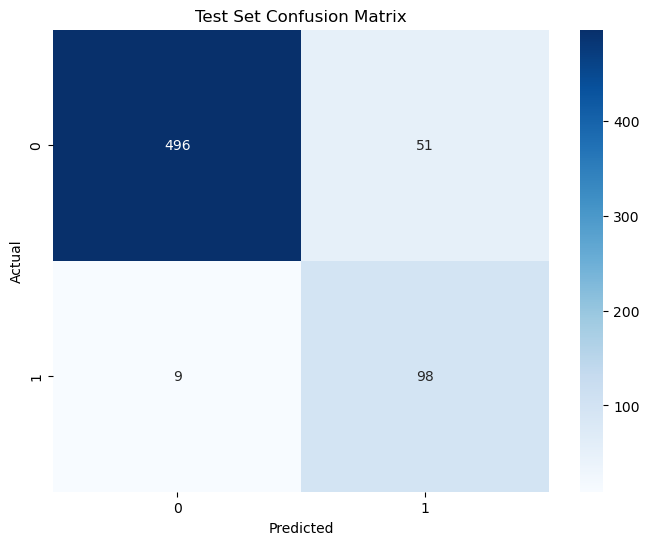

In [56]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

* TP: 98 --> Profit/Loss: 98 * (400 - 152): 24304
* TN: 496 --> Profit/Loss: 496 * 400: 198400
* FP: 51 --> Profit/Loss: 51 * (400 - 152): 12648
* FN: 9 --> Profit/Loss: 9 * (-400): -3600

Profit/Lost: 231752

##### 5.3.3.3. Explainable AI

In [57]:
encoder_columns = list(lgbmc_model[0].transformers_[0][1].get_feature_names_out())
remainder_columns = list(lgbmc_model[0].transformers_[1][1].get_feature_names_out())
columns = encoder_columns + remainder_columns

preprocessing_pipeline = lgbmc_model[:-2]

X_train_transformed = preprocessing_pipeline.transform(X_train_imputed)

model = lgbmc_model.named_steps['model']

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_train_transformed)

shap_values = shap.TreeExplainer(model,
                                 data=X_train_transformed,
                                 feature_perturbation='interventional',
                                 model_output='probability').shap_values(X_train_transformed)

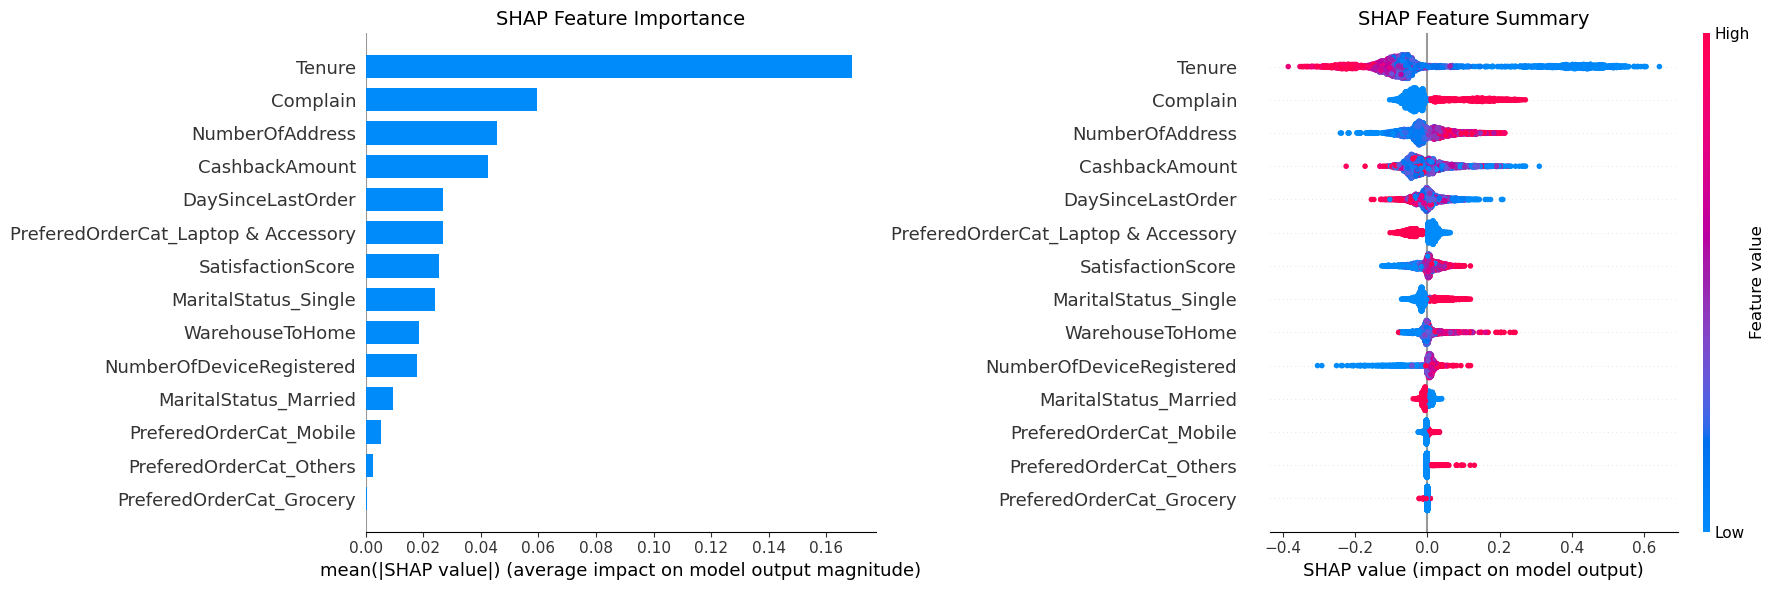

In [58]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
shap.summary_plot(shap_values, X_train_transformed, feature_names=columns,  title='Feature Importance', plot_type='bar', show=False, plot_size=None)
plt.title("SHAP Feature Importance", fontsize=14)

plt.subplot(1, 2, 2)
shap.summary_plot(shap_values, X_train_transformed, feature_names=columns,  title='SHAP Feature', show=False, plot_size=None)
plt.title("SHAP Feature Summary", fontsize=14)

plt.show()

**Feature Importance Summary**
* `Tenure`: This is the most influential feature, having the largest mean SHAP value. It indicates that the duration of a customer's relationship with the company significantly impacts the likelihood of churn or retention.
* `Complain`: The second most important feature, reflecting whether the customer has lodged a complaint.
* `NumberOfAddress`, `CashbackAmount`, & `DaySinceLastOrder`: These features also have notable impacts but are less influential compared to Tenure & Complain.
* `PreferredOrderCat_Grocery` and `PreferredOrderCat_Others`: These features have very low importance, showing minimal impact on the model's predictions.
* `PreferredOrderCat_Laptop & Accessory`: Among the PreferredOrderCat categories, this feature shows a much higher importance compared to others.

**SHAP Feature Sumary**
- For `Tenure`, higher values (red dots) reduce churn risk (negative SHAP value), while lower values (blue dots) increase churn risk.
- For `Complain`, having a complaint (likely red dots) strongly increases churn likelihood (positive SHAP values).
- For `NumberOfAddress`, having more number of address also strongly increases churn likelihood.
- `CashbackAmount` has a mixed influence, with some high values increasing churn and others decreasing it.
- Features such as `PreferredOrderCat_Grocery` have almost no variability, indicating their limited impact on predictions.

In [59]:
with open('lgbmc_model.pkl', 'wb') as file:
    pickle.dump(lgbmc_model, file)

## 6. Summary

### 6.1. Conclusions

In [60]:
models_evaluation(
    X_train=X_train_encoded, 
    y_train=y_train, 
    X_test=X_test_encoded, 
    y_test=y_test, 
    preprocessors=[RobustScaler(), RandomOverSampler(random_state=42)], 
    models=[LGBMClassifier(random_state=42, max_depth=4)]
)


Evaluating Model: LGBMClassifier

Train Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.99     0.92     0.95     0.93
Class 1         0.69     0.95     0.80     0.88
Accuracy       0.92
Macro Avg      0.84     0.93     0.88     0.91
Weighted Avg   0.94     0.92     0.93     0.92
Total Profit/Loss: 939328.00

Test Set Metrics
Class          Precision Recall    F1-Score  F2-Score
Class 0         0.98     0.91     0.94     0.92
Class 1         0.66     0.92     0.77     0.85
Accuracy       0.91
Macro Avg      0.82     0.91     0.85     0.89
Weighted Avg   0.93     0.91     0.91     0.91
Total Profit/Loss: 231752.00


The goal of this project is to predict whether a customer will churn or continue using the services of an e-commerce company. The model developed in this notebook is effective and does not overfit, making it a reliable tool for addressing this problem.

**Metrics:**

The main metric is F2-Score. F2-Score gives more weight to recall than precision, making it suitable for problems where detecting all churners is more important than minimizing false positives. In this case:
* Train set F2-Score: 0.93 for Class 0 and 0.88 for Class 1.
* Test set F2-Score: 0.92 for Class 0 and 0.85 for Class 1.

The F2-Score provides insight into how well the model identifies churners, with a slightly higher emphasis on minimizing false negatives (missed churners). The small difference between train and test F2-Scores shows good model performance without overfitting.

**Business Impact:**

By implementing this model, the predicted revenue will increase to US$231,752.00, which is 5.9% higher than the revenue when no model is used and no discounts are provided. Importantly, not offering discounts could potentially harm revenue, as it would result in losing customers who might have otherwise been retained.

Furthermore, this revenue is 42.9% higher than the revenue generated by giving a blanket discount to all customers without any predictive model. This demonstrates that the model helps in making more targeted decisions, offering discounts only to those customers at risk of churning, thus improving the company’s profitability.

In conclusion, the developed model is effective in predicting customer churn and enables the company to optimize its revenue by targeting at-risk customers more accurately and minimizing unnecessary discounting.

**Factors Affecting Customer Churn:**

Based on the Feature Importance and Summary Plot, the top 4 factors that influence the prediction of Customer Churn, in order, are:

1. Tenure

The smaller the value of Tenure, the newer the customer is to the subscription, and the higher the likelihood of churn. Conversely, the longer a customer has been subscribed, the more likely they are to remain loyal to the company’s services.

2. Complain

The larger the value of Complain, the higher the likelihood that the customer will churn. A high value indicates that the customer has lodged a complaint or is dissatisfied with the service.

3. NumberOfAddress

The larger the value of NumberOfAddress, the higher the likelihood that the customer will churn. A higher value indicates that the customer has registered more addresses, which may suggest that the customer is moving or changing locations.

4. Cashback Amount

A smaller cashback amount increases the likelihood of customer churn. Based on the plot, it is estimated that a cashback amount ≥ US$150 reduces the chances of churn compared to the overall churn rate.

### 6.2. Recommendations

1. New Customers (Low Tenure): The data shows that new customers with lower tenure are more likely to churn. It is essential to focus on improving the onboarding experience and providing strong incentives to retain new users, ensuring they have a positive initial experience.

2. Customer Complaints: Customers who have lodged complaints are more likely to churn. Addressing customer complaints quickly and effectively is crucial. Implementing a proactive customer service strategy to resolve issues could help reduce churn.

3. Frequent Address Changes (High NumberOfAddress): Customers with multiple addresses are more likely to churn, potentially due to moving or changing locations, which may increase delivery costs. Offering tailored services or loyalty programs to these customers could encourage them to remain with the company, even in the face of life changes.

4. Cashback Amount: Customers with lower cashback amounts are more likely to churn. Increasing cashback offers or providing personalized discounts could help improve customer retention and reduce churn.

### 6.3. Limitations

1. Data: The small size of the dataset may restrict the model's ability to accurately capture churn probabilities.

2. Feature: Several potentially valuable features, such as total amount spent or total transactions, have not yet been explored, and incorporating them could enhance the model's predictive capabilities.

3. Data Shift: Customer behavior may evolve over time, which could affect the model's performance if it is not updated to reflect these changes.